In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

In [2]:
data_path = "/media/sparsh/CaptainSlow/Programming Stuff/Programming Stuff/Code _n_ Stuff/All Projects/All Projects/Mind Wandering 2/Mind Wandering Durinng Live Lectures dataset"
subject_file = "MWEEG_Subject_0.npz"

In [3]:
data = np.load(os.path.join(data_path, subject_file))
data

NpzFile '/media/sparsh/CaptainSlow/Programming Stuff/Programming Stuff/Code _n_ Stuff/All Projects/All Projects/Mind Wandering 2/Mind Wandering Durinng Live Lectures dataset/MWEEG_Subject_0.npz' with keys: EEG, TriggerValues, SampleTime, TriggerTime

In [4]:
eeg = data["EEG"]              # shape (16, T)
triggervalues = data["TriggerValues"]
sampletimes = data["SampleTime"]
triggertime = data["TriggerTime"]

print("EEG shape:", eeg.shape)
print("Trigger values:", triggervalues.shape)
print("Sample times:", sampletimes.shape)
print("Trigger time:", triggertime.shape)

EEG shape: (16, 1025138)
Trigger values: (13,)
Sample times: (1025138,)
Trigger time: (1025138,)


In [5]:
import mne

sfreq = 1024  # Sampling frequency
ch_names = ["Fpz", "Fp1", "Fp2", "F7", "F8", "F3", "F4", "T7", "T8", "C3", "C4","P7", "P8", "O1", "O2", "Oz"]
ch_types = ["eeg"] * eeg.shape[0]

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg, info)
print(raw)

Creating RawArray with float64 data, n_channels=16, n_times=1025138
    Range : 0 ... 1025137 =      0.000 ...  1001.110 secs
Ready.
<RawArray | 16 x 1025138 (1001.1 s), ~125.2 MiB, data loaded>


Using matplotlib as 2D backend.


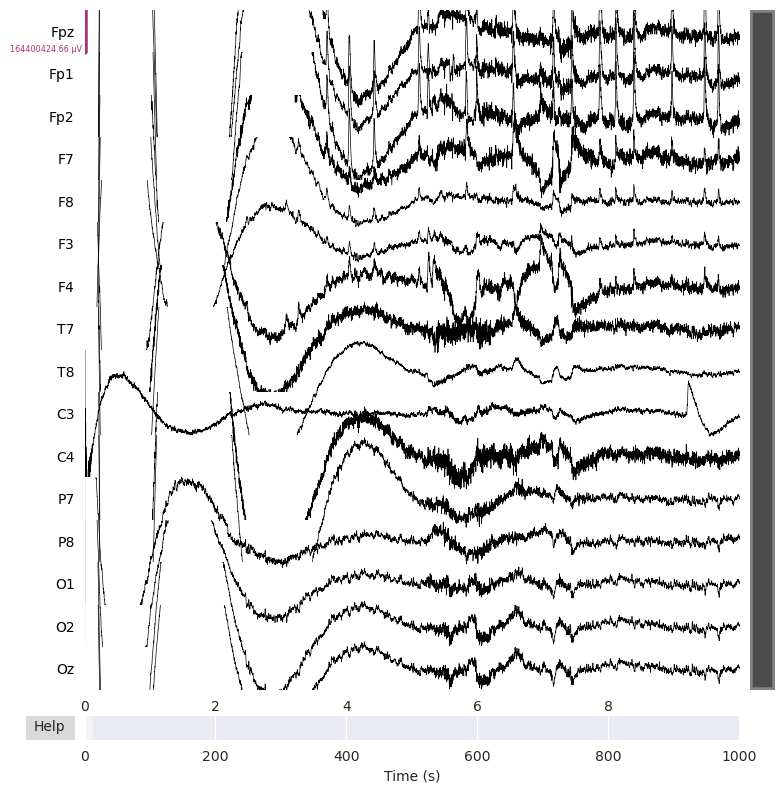

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_610927/649542911.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/home/sparsh/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


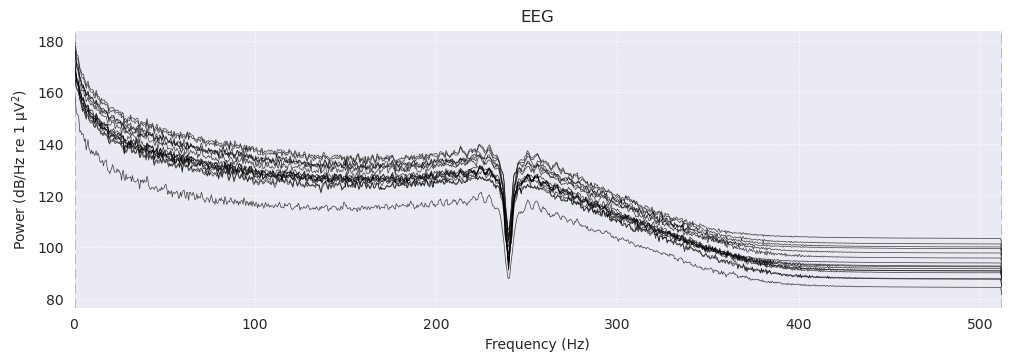

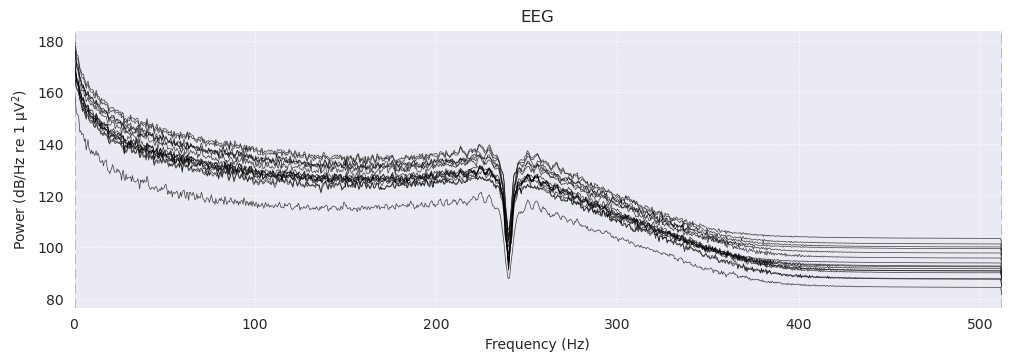

In [6]:
raw.plot(title="Raw EEG Data (Unfiltered)", scalings='auto')
raw.compute_psd().plot()

In [7]:
trigger_indices = np.where(triggertime != 0)[0]
print("Detected trigger indices:", trigger_indices.shape)

n = min(len(trigger_indices), len(triggervalues))
trigger_indices = trigger_indices[:n]
triggervalues = triggervalues[:n]

Detected trigger indices: (16,)


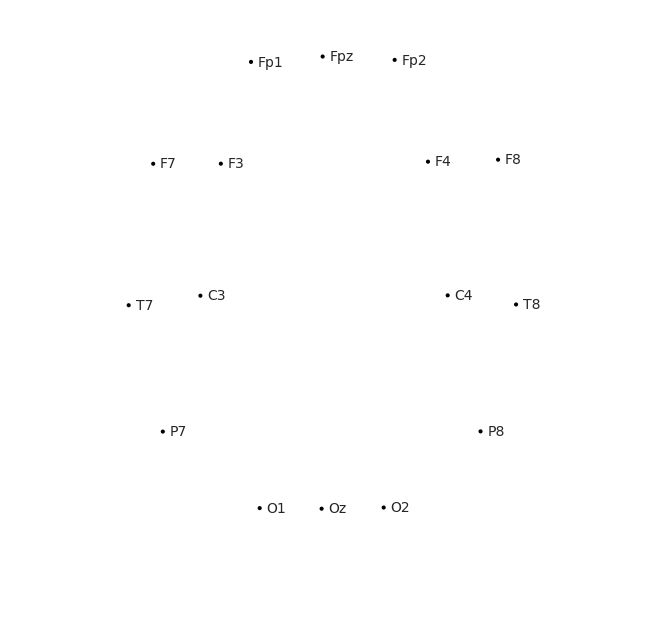

In [8]:
# Set the standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

raw.plot_sensors(ch_type='eeg', show_names=True)  # sensor location ko plot karenge
plt.show()

Fitting ICA to data using 16 channels (please be patient, this may take a while)


/tmp/ipykernel_610927/1291875349.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 16 components
Fitting ICA took 9.4s.


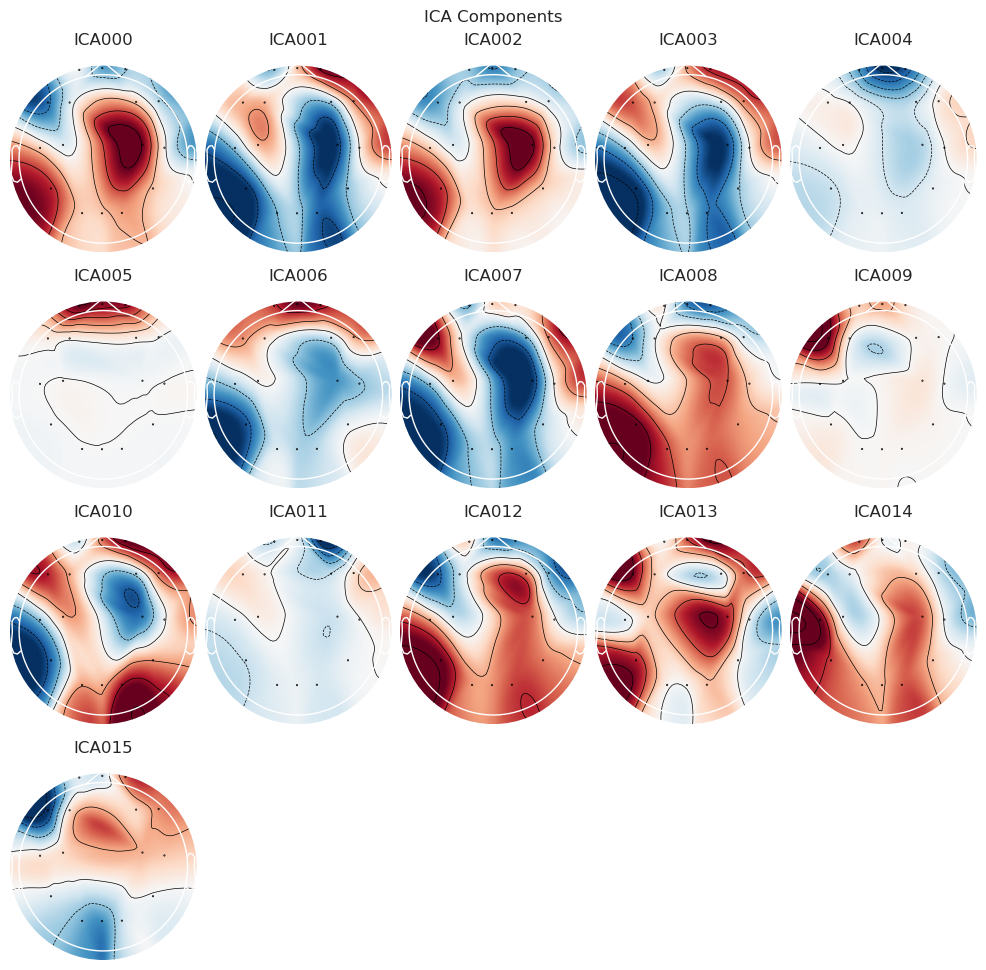

In [9]:
ica = mne.preprocessing.ICA(n_components=16, random_state=42, max_iter="auto")
ica.fit(raw)

# Visualize ICA components
ica.plot_components(title="ICA Components")
plt.show()

In [10]:
eog_inds, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp1','Fp2'])
print(f"EOG-related components found: {eog_inds}")

if eog_inds:
    ica.plot_scores(eog_scores, title="EOG Correlation Scores")
    plt.show()

    ica.plot_properties(raw, picks=eog_inds, title="Component Properties")
    plt.show()
    ica.exclude = eog_inds
else:
    print("No EOG components found automatically. Manual inspection is recommended.")

Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25

⏳ Detecting muscle (EMG) artifacts...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 123 samples (0.120 s)

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1

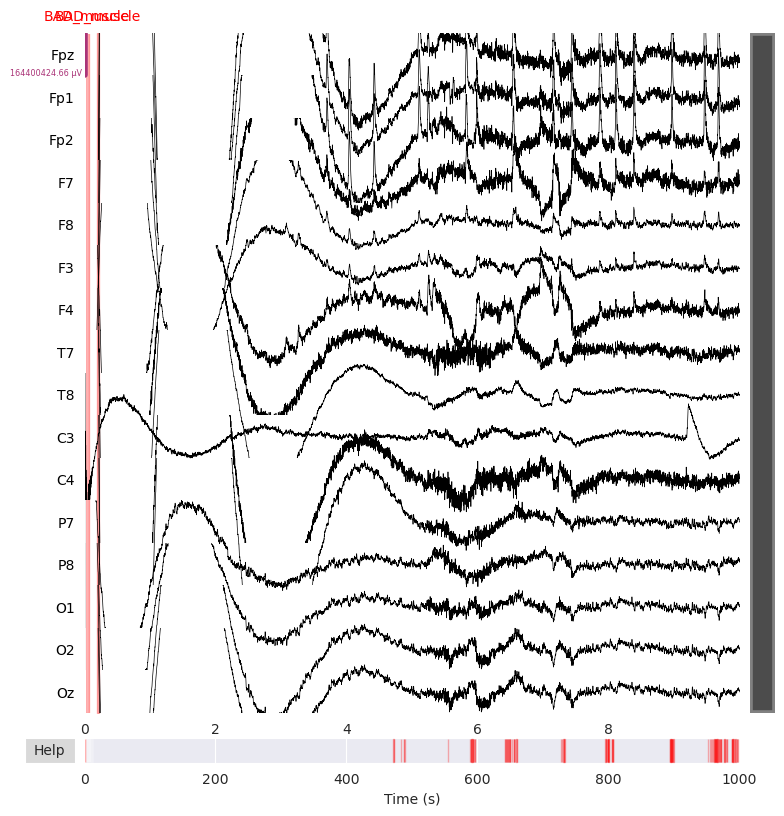

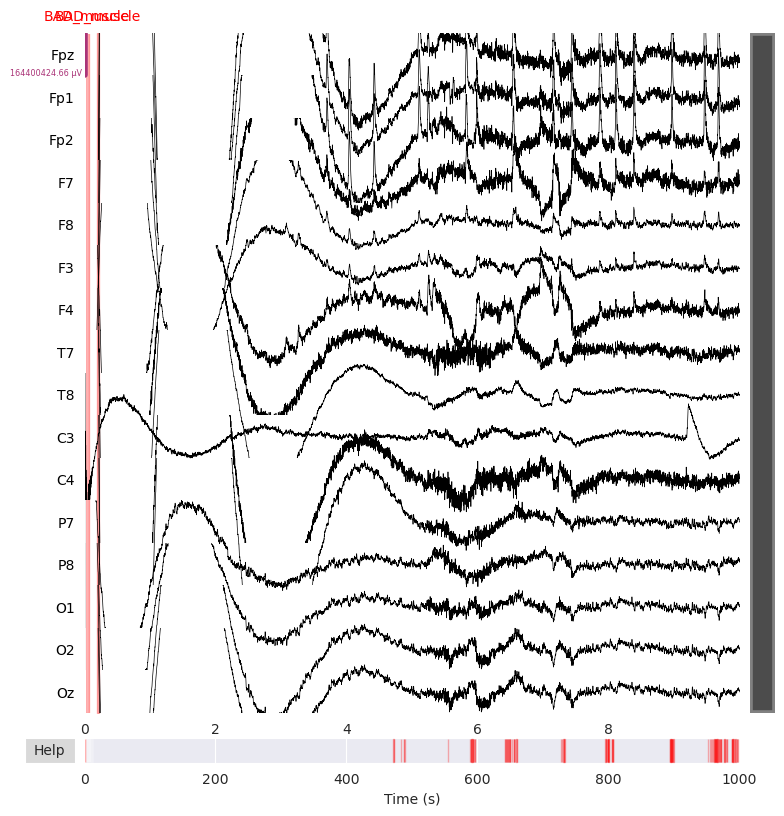

In [11]:
print("⏳ Detecting muscle (EMG) artifacts...")
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw, ch_type="eeg", threshold=4.0
)
print(f"Detected {len(annot_muscle)} muscle artifact segments.")
raw.set_annotations(annot_muscle)
raw.plot(duration=10, n_channels=16, title="Muscle Artifacts (Highlighted)", scalings='auto')

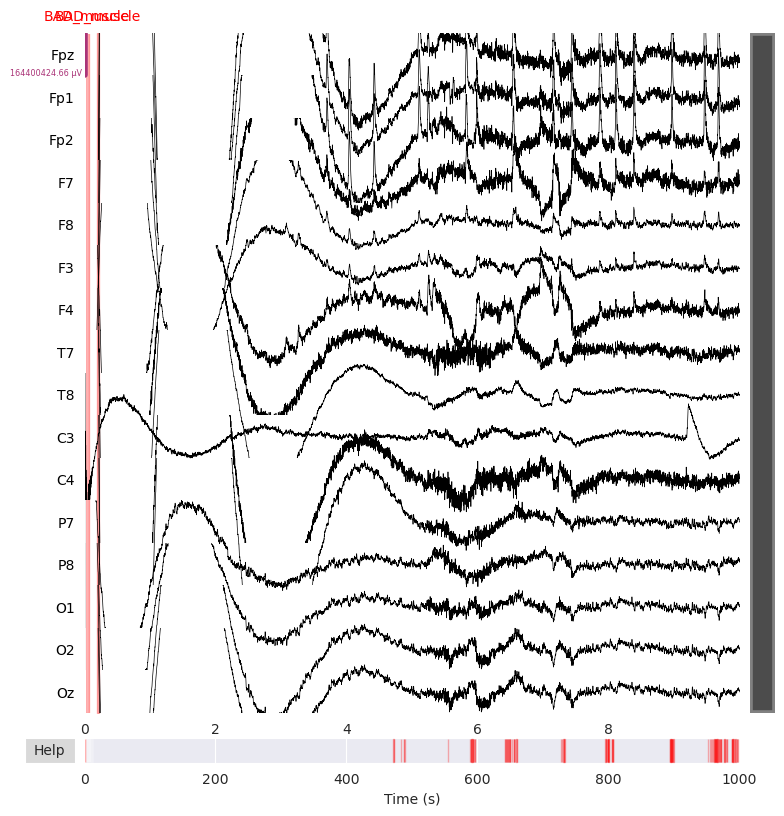

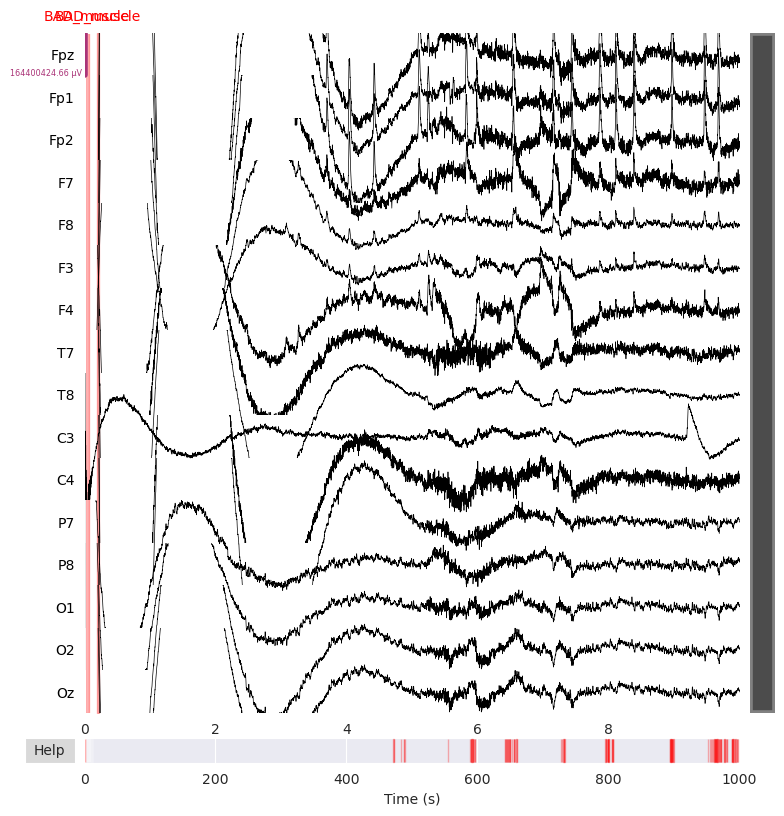

In [12]:
raw.plot(scalings='auto')

In [13]:
raw.filter(1., 30., fir_design="firwin")   # bandpass filter
raw.notch_filter(freqs=60)  # powerline noise filter


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

<RawArray | 16 x 1025138 (1001.1 s), ~125.2 MiB, data loaded>

Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (3.302 s)



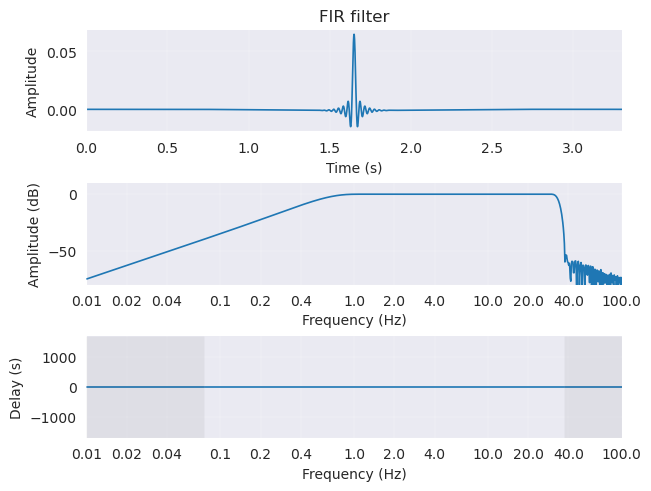

In [14]:
import matplotlib.pyplot as plt

filt = mne.filter.create_filter(raw.get_data(), sfreq=sfreq, l_freq=1.0, h_freq=30.0)
mne.viz.plot_filter(filt, sfreq, flim=(0.01, 100))
plt.show()

Setting 25718 of 1025138 (2.51%) samples to NaN, retaining 999420 (97.49%) samples.
Effective window size : 2.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


/home/sparsh/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 128, using nperseg = 128
  return _func(*args, **kwargs)
/home/sparsh/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1291, using nperseg = 1291
  return _func(*args, **kwargs)
/home/sparsh/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 149, using nperseg = 149
  return _func(*args, **kwargs)
/home/sparsh/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1264, using nperseg = 1264
  return _func(*args, **kwargs)
/home/sparsh/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 

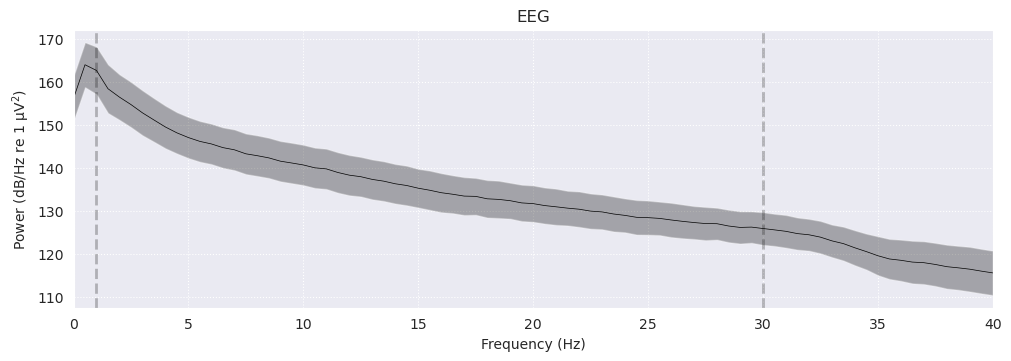

In [15]:
raw.compute_psd(fmax = 40).plot(average = True)

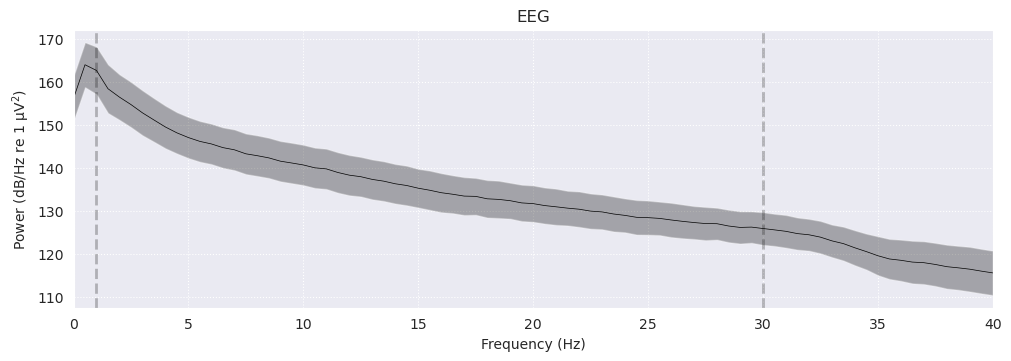

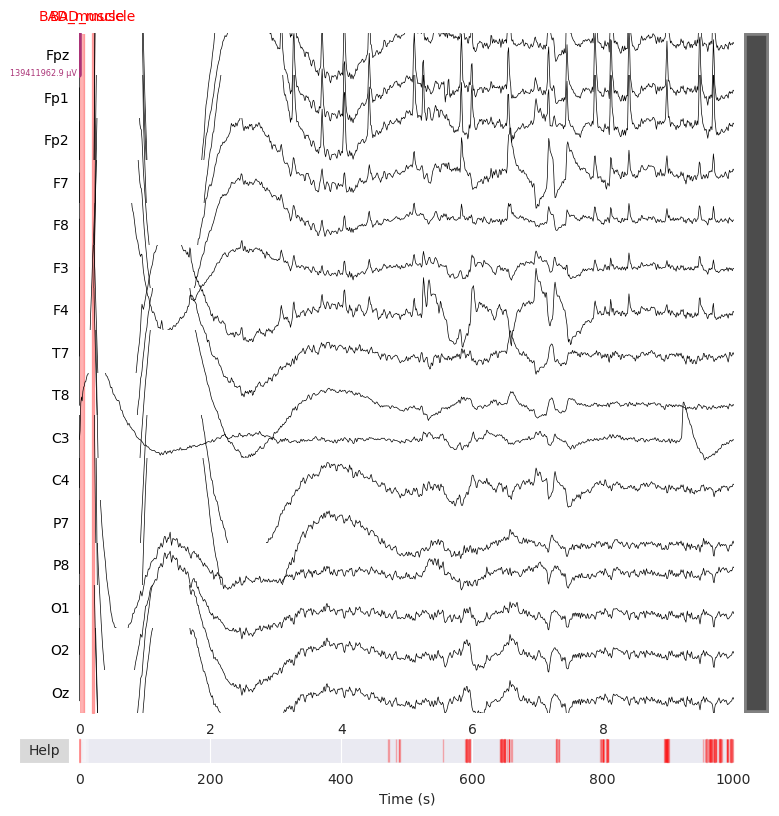

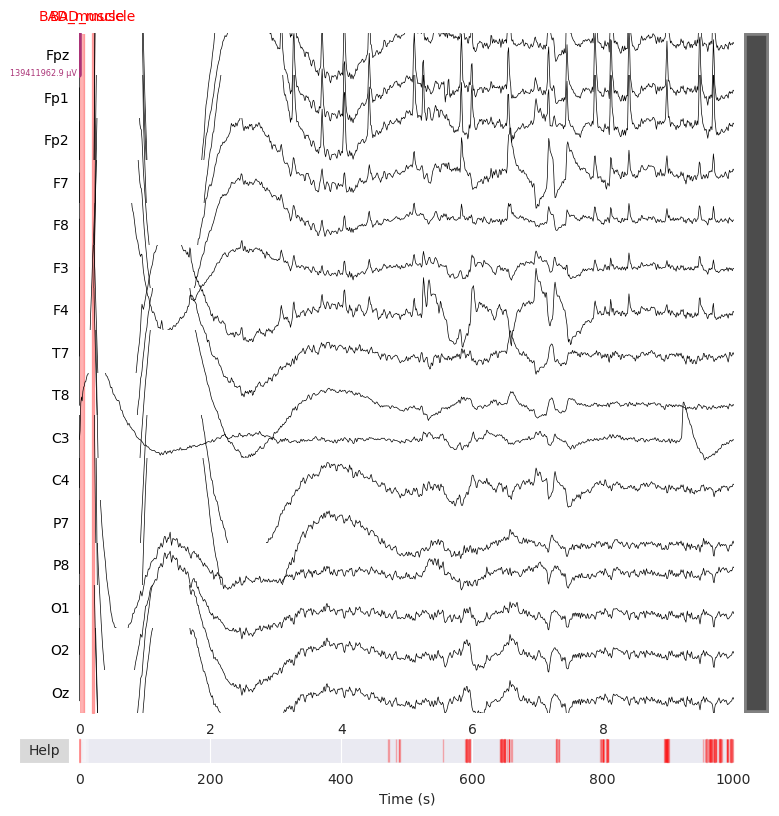

In [16]:
raw.plot(title="Raw EEG Data (Filter)", scalings='auto')

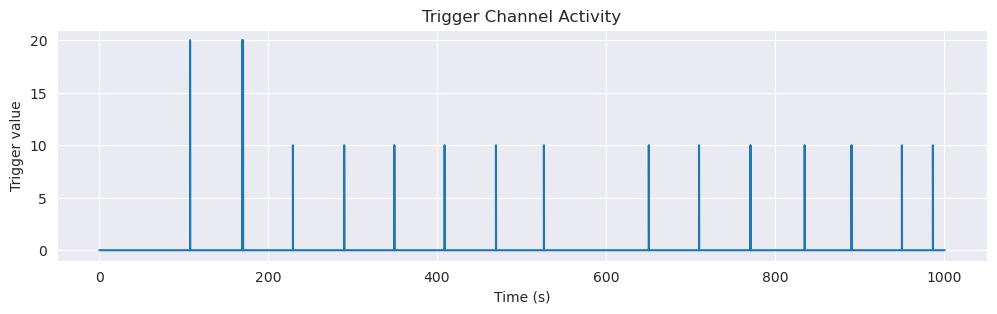

In [17]:
plt.figure(figsize=(12, 3))
time = np.arange(len(triggertime)) / sfreq
plt.plot(time, triggertime)
plt.xlabel("Time (s)")
plt.ylabel("Trigger value")
plt.title("Trigger Channel Activity")
plt.grid(True)
plt.show()

#### EPOCHS

In [18]:

events = np.column_stack((trigger_indices, np.zeros(len(trigger_indices), dtype=int), triggervalues.astype(int)))
tmin = -15.0
tmax = 0.0

epochs = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax, baseline=(None,0), preload=True)
epochs.get_data().shape

Not setting metadata
13 matching events found
Setting baseline interval to [-15.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 13 events and 15361 original time points ...
1 bad epochs dropped


(12, 16, 15361)

##### Mini epochs (breaking the 15 second epochs into 3 second epochs )

In [19]:
re_epoch_dur = 3.0
start_times = np.arange(tmin, tmax, re_epoch_dur)

mini_epochs = []
labels = []

for ep_idx in range(len(epochs)):
    epoch = epochs[ep_idx]
    for s in start_times:
        mini = epoch.copy().crop(tmin=s, tmax=s + re_epoch_dur)
        mini_epochs.append(mini.get_data())
        labels.append(epochs.events[ep_idx, 2])

mini_epochs = np.concatenate(mini_epochs, axis=0)
labels = np.array(labels)

print("Mini-epochs shape:", mini_epochs.shape)
print("Labels shape:", labels.shape)

mini_info = raw.info.copy()
mini_events = np.column_stack((np.arange(len(labels)),
                               np.zeros(len(labels), dtype=int),
                               labels))
mini_epochs_mne = mne.EpochsArray(mini_epochs, mini_info,
                                  events=mini_events, tmin=0)

Mini-epochs shape: (60, 16, 3073)
Labels shape: (60,)
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


#### AutoReject

/home/sparsh/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⏳ Running AutoReject on mini-epochs ...
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 16/16 [00:00<00:00,  178.42it/s]
100%|██████████| Computing thresholds ... : 16/16 [00:00<00:00,  400.66it/s]


  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  7%|▋         | Repairing epochs : 4/60 [00:00<00:00,  238.50it/s]

 15%|█▌        | Repairing epochs : 9/60 [00:00<00:00,  260.83it/s]

 23%|██▎       | Repairing epochs : 14/60 [00:00<00:00,  276.87it/s]

 32%|███▏      | Repairing epochs : 19/60 [00:00<00:00,  283.75it/s]

 40%|████      | Repairing epochs : 24/60 [00:00<00:00,  278.64it/s]

 45%|████▌     | Repairing epochs : 27/60 [00:00<00:00,  260.20it/s]

 52%|█████▏    | Repairing epochs : 31/60 [00:00<00:00,  258.26it/s]

 60%|██████    | Repairing epochs : 36/60 [00:00<00:00,  258.43it/s]

 68%|██████▊   | Repairing epochs : 41/60 [00:00<00:00,  261.30it/s]

 77%|███████▋  | Repairing epochs : 46/60 [00:00<00:00,  261.99it/s]

 83%|████████▎ | Repairing epochs : 50/60 [00:00<00:00,  259.37it/s]

 92%|█████





Estimated consensus=0.50 and n_interpolate=4




  0%|          | Repairing epochs : 0/60 [00:00<?,       ?it/s]

  7%|▋         | Repairing epochs : 4/60 [00:00<00:00,  210.31it/s]

 13%|█▎        | Repairing epochs : 8/60 [00:00<00:00,  222.90it/s]

 20%|██        | Repairing epochs : 12/60 [00:00<00:00,  227.01it/s]

 25%|██▌       | Repairing epochs : 15/60 [00:00<00:00,  207.36it/s]

 32%|███▏      | Repairing epochs : 19/60 [00:00<00:00,  208.41it/s]

 38%|███▊      | Repairing epochs : 23/60 [00:00<00:00,  209.89it/s]

 45%|████▌     | Repairing epochs : 27/60 [00:00<00:00,  212.26it/s]

 53%|█████▎    | Repairing epochs : 32/60 [00:00<00:00,  221.27it/s]

 60%|██████    | Repairing epochs : 36/60 [00:00<00:00,  221.10it/s]

 67%|██████▋   | Repairing epochs : 40/60 [00:00<00:00,  221.97it/s]

 73%|███████▎  | Repairing epochs : 44/60 [00:00<00:00,  221.71it/s]

 80%|████████  | Repairing epochs : 48/60 [00:00<00:00,  221.01it/s]

 87%|████████▋ | Repairing epochs : 52/60 [00:00<00:00,  221.11it/s]

 93%|█████████▎| Repairin

Dropped 2 epochs: 29, 55
✅ AutoReject complete.
Original epochs: 60
Cleaned epochs: 58
Original labels: 60
Cleaned labels: 58


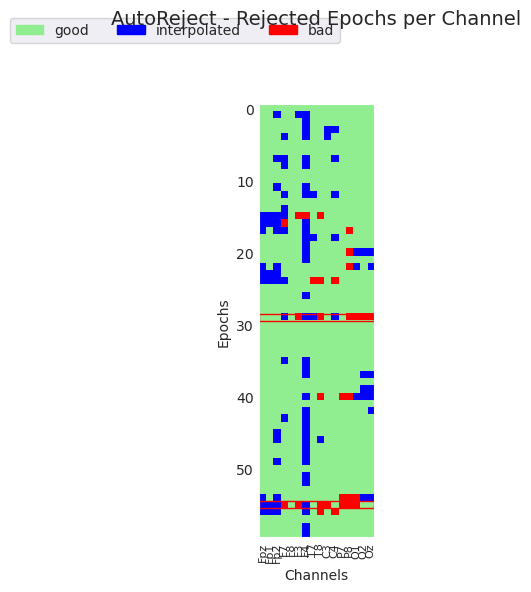

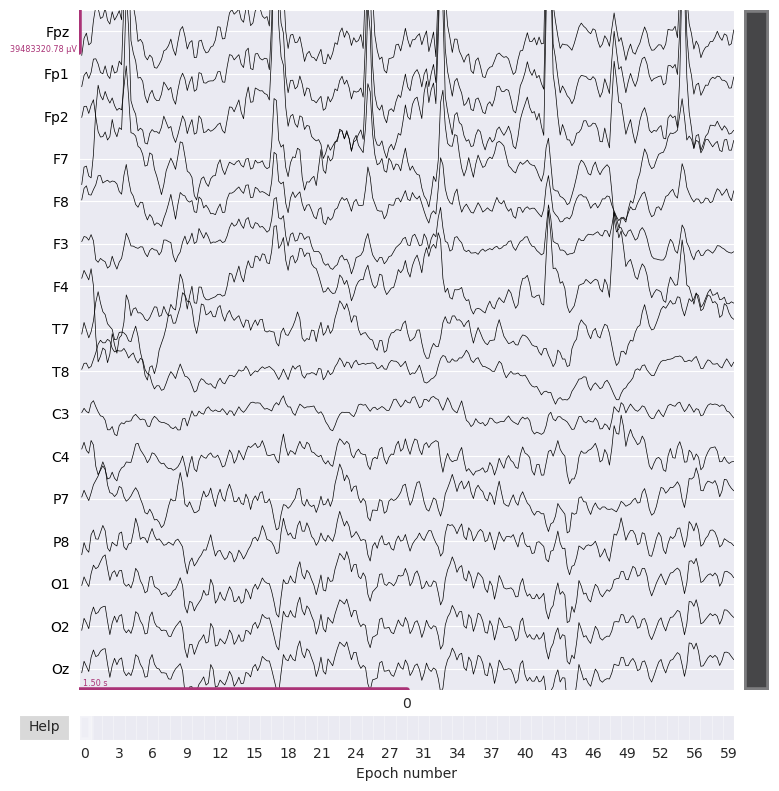

🎯 Epochs and labels perfectly aligned after AutoReject.


In [20]:
from autoreject import AutoReject
import numpy as np
import matplotlib.pyplot as plt

print("⏳ Running AutoReject on mini-epochs ...")

# 1️⃣ Initialize AutoReject
ar = AutoReject(
    random_state=42,
    n_jobs=-1,        # use all CPU cores
    verbose='tqdm'    # show progress bar
)

# 2️⃣ Fit & Transform
epochs_final, reject_log = ar.fit_transform(mini_epochs_mne, return_log=True)

print("✅ AutoReject complete.")
print(f"Original epochs: {len(mini_epochs_mne)}")
print(f"Cleaned epochs: {len(epochs_final)}")


kept_mask = ~reject_log.bad_epochs
labels_final = np.array(labels)[kept_mask]

print(f"Original labels: {len(labels)}")
print(f"Cleaned labels: {len(labels_final)}")

# 4️⃣ Sanity check
if len(epochs_final) != len(labels_final):
    raise ValueError("⚠️ Mismatch between epochs and labels count!")

# 5️⃣ Optional: visualize which epochs were rejected
fig = reject_log.plot(show=False)
plt.suptitle("AutoReject - Rejected Epochs per Channel", fontsize=14)

# 6️⃣ Optional: visualize one clean vs one bad epoch (if you want)
# e.g., plot the first remaining clean epoch
epochs_final.plot(n_epochs=1, n_channels=16, title="Example Cleaned Epoch", scalings = 'auto')

print("🎯 Epochs and labels perfectly aligned after AutoReject.")


Plotting comparison before/after AutoReject...


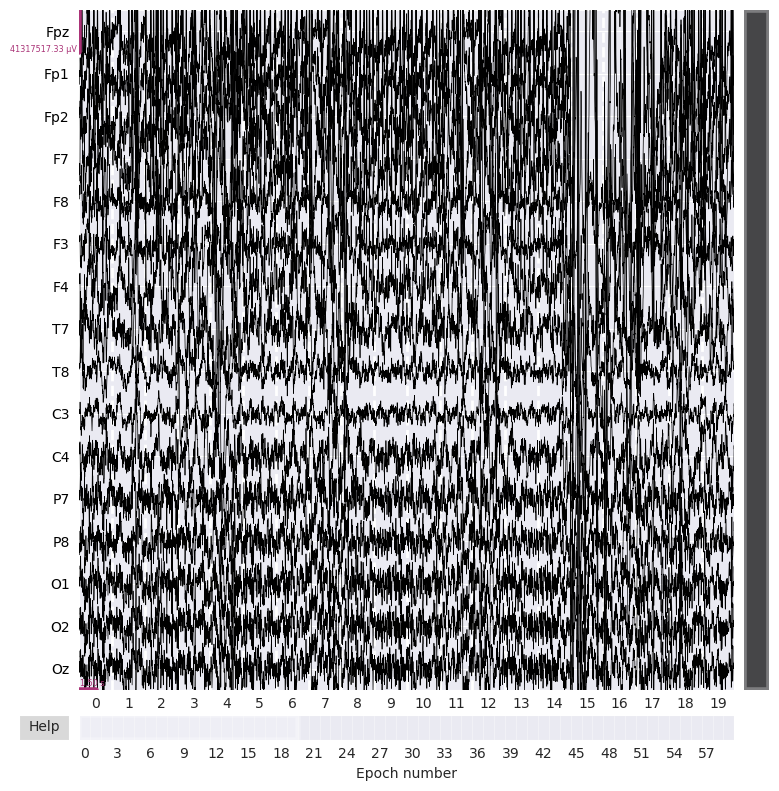

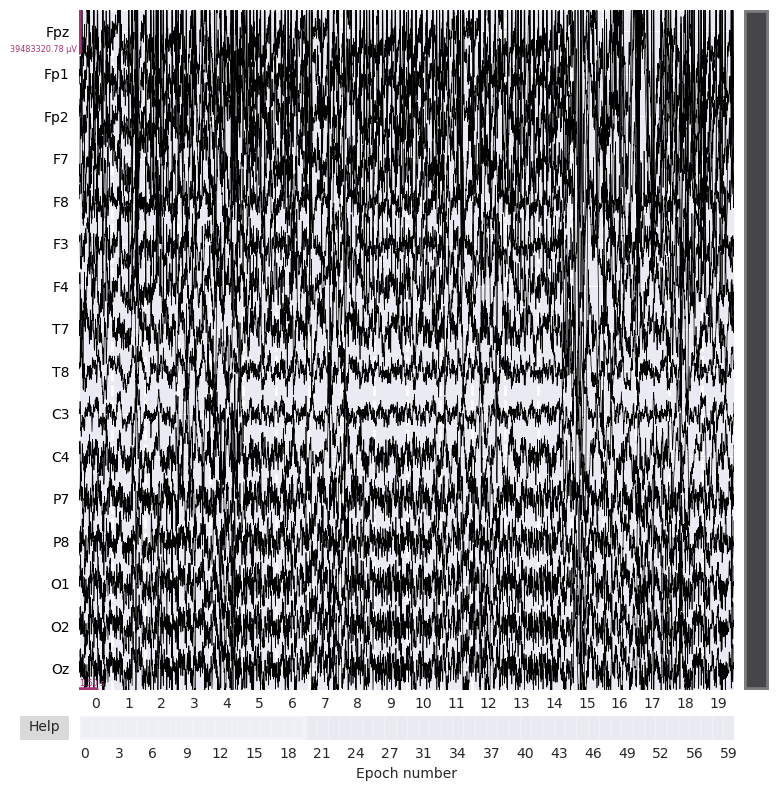

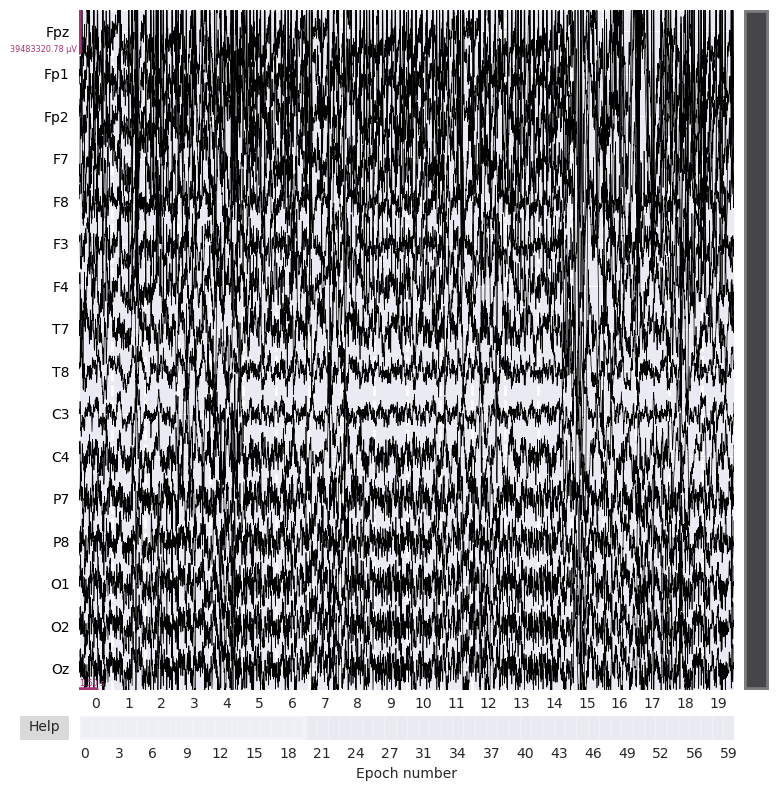

In [21]:
print("Plotting comparison before/after AutoReject...")

# Plot the average of all epochs *before* cleaning
mini_epochs_mne.plot(scalings='auto')
plt.show()

# Plot the average of all epochs *after* cleaning
epochs_final.plot(scalings='auto')

Clean data shape: (58, 16, 3073)
Clean labels shape: (58,)


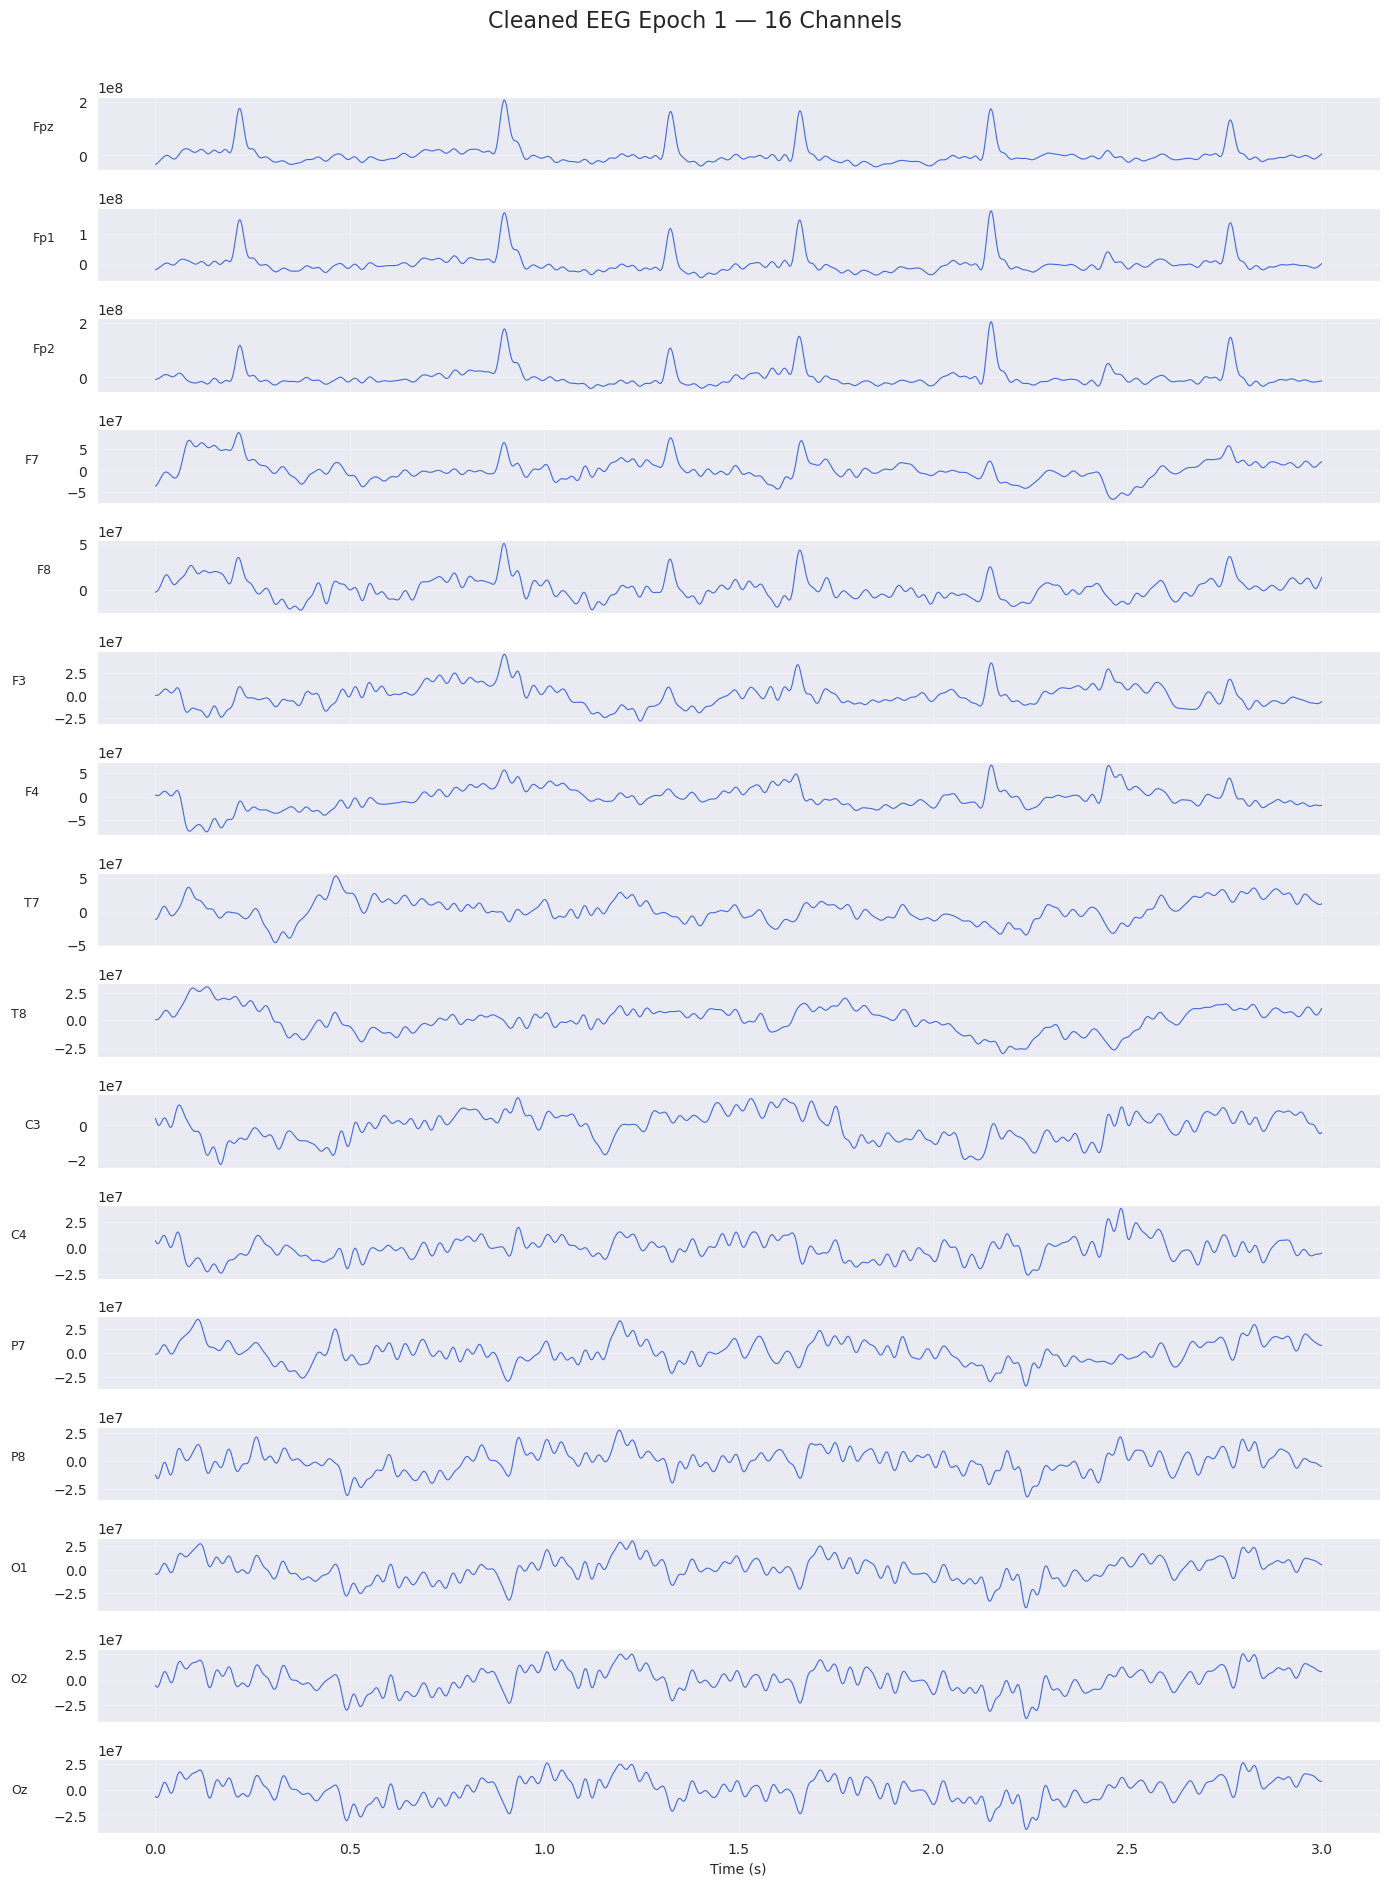

In [30]:
X_clean = epochs_final.get_data()          # shape → (n_epochs, n_channels, n_times)
labels_clean = epochs_final.events[:, 2]   # event codes (labels)

print("Clean data shape:", X_clean.shape)
print("Clean labels shape:", labels_clean.shape)

n_epochs, n_channels, n_time = X_clean.shape
fs = 1024
time = np.arange(n_time) / fs

# --- Select which epoch to visualize ---
epoch_idx = 0  # change index to visualize a different epoch

# --- Plot each channel separately ---
fig, axes = plt.subplots(n_channels, 1, figsize=(14, n_channels * 1.2), sharex=True)
fig.suptitle(f"Cleaned EEG Epoch {epoch_idx + 1} — {n_channels} Channels", fontsize=16)

for ch in range(n_channels):
    axes[ch].plot(time, X_clean[epoch_idx, ch, :] * 1e6, color='royalblue', linewidth=0.8)
    axes[ch].set_ylabel(ch_names[ch], rotation=0, labelpad=25, fontsize=9)
    axes[ch].grid(alpha=0.3)

axes[-1].set_xlabel("Time (s)")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [29]:
labels_clean.shape

(58,)